In [1]:
import gym
import gym_backgammon
import time
from itertools import count
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import randint
import numpy as np
from gym_backgammon.envs.backgammon import WHITE, BLACK, COLORS, TOKEN
import datetime
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from itertools import count
from gym_backgammon.envs.backgammon import WHITE, BLACK

env = gym.make('gym_backgammon:backgammon-v0')

# if GPU is available this code will state 1
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
random.seed(4)
np.random.seed(4)
exploration_rate = 0.9
learning_rate = 0.001
lambda_ = 0.8
model = Sequential([
                Dense(80, activation='relu', input_shape=(198,)), # 29 features for board state
                Dense(1, activation="sigmoid")  # Output: Estimated value of the state
            ])
optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model.compile(optimizer=optimizer,
      loss='mean_squared_error')
        

In [3]:
def td_lambda_update(state, next_state, reward, model, eligibility_traces, alpha=learning_rate, gamma=0.99, lambda_=0.8):
    total_loss = 0

    
    with tf.GradientTape() as tape:
        # Predict current and next state values
        # V_t = model(tf.convert_to_tensor([state], dtype=tf.float32))  # Shape: (1, 1)
        # V_t_plus_1 = model(tf.convert_to_tensor([next_state], dtype=tf.float32))  # Shape: (1, 1)
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        next_state = tf.convert_to_tensor([next_state], dtype=tf.float32)
        # Compute TD error (td_error)
        td_error = reward + gamma * tf.squeeze(next_state) - tf.squeeze(state)

        # Calculate gradients for the current state's value prediction
    gradients = tape.gradient(tf.squeeze(state), model.trainable_variables)

    # Update eligibility traces and model weights
    for i, gradient in enumerate(gradients):
        if gradient is not None:
            eligibility_traces[i] = gamma * lambda_ * eligibility_traces[i] + gradient
            model.trainable_variables[i].assign_add(alpha * td_error * eligibility_traces[i])

    

    return td_error


def td_lambda_update(observation, next_observation, reward, model, eligibility_traces, alpha=0.001, gamma=0.99, lambda_=0.8):
    """
    Perform a TD(λ) update for a given state transition.

    Args:
        observation (array-like): Current observation/state.
        next_observation (array-like): Next observation/state.
        reward (float): Reward for the transition.
        model (tf.keras.Model): The value function approximator.
        eligibility_traces (list): List of eligibility traces for each parameter in the model.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        lambda_ (float): Decay factor for eligibility traces.

    Returns:
        float: TD error for the transition.
    """
    # Convert observations to tensors
    observation_tensor = tf.convert_to_tensor([observation], dtype=tf.float32)
    next_observation_tensor = tf.convert_to_tensor([next_observation], dtype=tf.float32)

    # Compute TD error and gradients
    with tf.GradientTape() as tape:
        # Compute V(s) and V(s') within the gradient context
        value_s = tf.squeeze(model(observation_tensor))  # V(s)
        value_s_next = tf.squeeze(model(next_observation_tensor))  # V(s')

        # Compute TD error: δ = r + γ * V(s') - V(s)
        td_error = reward + gamma * value_s_next - value_s

    # Compute gradients of V(s) with respect to model parameters
    gradients = tape.gradient(value_s, model.trainable_variables)

    # Update eligibility traces and apply parameter updates
    for i, grad in enumerate(gradients):
        if grad is not None:
            # Update eligibility trace
            eligibility_traces[i] = lambda_ * eligibility_traces[i] + grad

            # Update weights
            model.trainable_variables[i].assign_add(alpha * td_error * eligibility_traces[i])

    return td_error.numpy()



In [4]:
class TDAgent:
    def __init__(self, color, model):
        self.color = color
        self.model = model
        self.name = 'TDAgent({})'.format(COLORS[color])

    def roll_dice(self):
        return (-randint(1, 6), -randint(1, 6)) if self.color == WHITE else (randint(1, 6), randint(1, 6))

    def choose_best_action(self, actions, env,exploration_rate):
        best_action = None
        observations = []
        if actions:
            actions = list(actions)
            
            # print(exploration_rate)
            if random.uniform(0,1)<exploration_rate:
                best_action = random.choice(actions)
            else:
                tmp_counter = env.counter
                env.counter = 0
                state = env.game.save_state()
                
                # Iterate over all the legal moves and pick the best action
                for i, action in enumerate(actions):
                    observation, reward, done, info = env.step(action)
                    observations.append(observation)
    
                    # restore the board and other variables (undo the action)
                    env.game.restore_state(state)
                observations = np.array(observations)
                values = self.model(observations).flatten()
                
                # practical-issues-in-temporal-difference-learning, pag.3
                # ... the network's output P_t is an estimate of White's probability of winning from board position x_t.
                # ... the move which is selected at each time step is the move which maximizes P_t when White is to play and minimizes P_t when Black is to play.
                best_action_index = int(np.argmax(values)) if self.color == WHITE else int(np.argmin(values))
                best_action = actions[best_action_index]
                env.counter = tmp_counter

        return best_action

In [5]:
last_epoch = 0
epochs = 30000
total_losses = []
td_alpha = 0.005
wins = {WHITE: 0, BLACK: 0}


agents = {WHITE: TDAgent(WHITE, model=model), BLACK: TDAgent(BLACK, model=model)}


durations = []
steps = 0
start_training = time.time()

# model = tf.keras.models.load_model("./gym_env_models/backgammon_RLmodel_gym_80_3_400.h5")

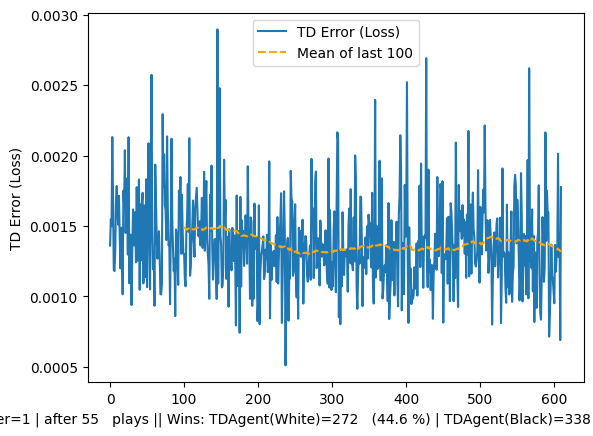


KeyboardInterrupt



In [6]:

for epoch in range(last_epoch, epochs):
    t = time.time()
    if epoch % 1000 == 0 and td_alpha > 0.00005:
        td_alpha *= 0.8
      #   model.compile(optimizer=optimizer,
      # loss='mean_squared_error')
    if exploration_rate > 0.1:
        exploration_rate -= 0.00003
    
    eligibility_traces = [tf.zeros_like(var) for var in model.trainable_variables]

    agent_color, first_roll, observation = env.reset()
    agent = agents[agent_color]

    
    agents = {WHITE: TDAgent(WHITE, model=model), BLACK: TDAgent(BLACK, model=model)}
    losses = []
    for i in count():
        if first_roll:
            roll = first_roll
            first_roll = None
        else:
            roll = agent.roll_dice()
    
        # p = model.predict(np.array([observation]))
        # print(p)
        actions = env.get_valid_actions(roll)
        action = agent.choose_best_action(actions, env, exploration_rate)
        observation_next, reward, done, winner = env.step(action)
        # p_next = model.predict(np.array([observation_next]))
        
        
    
        if done:
            if winner is not None:
                loss = td_lambda_update(observation, observation_next, reward, model, eligibility_traces, alpha=td_alpha)
                
                wins[agent.color] += 1
    
            tot = sum(wins.values())
            tot = tot if tot > 0 else 1
    
            text = "Game={:<6d} | Winner={} | after {:<4} plays || Wins: {}={:<6}({:<5.1f}%) | {}={:<6}({:<5.1f}%) | Duration={:<.3f} sec".format(epoch + 1, winner, i,
                agents[WHITE].name, wins[WHITE], (wins[WHITE] / tot) * 100,
                agents[BLACK].name, wins[BLACK], (wins[BLACK] / tot) * 100, time.time() - t)
            # print(text)
            
            durations.append(time.time() - t)
            steps += i
            # print(durations)
            # print(steps)
            break
        else:
            loss = td_lambda_update(observation, observation_next, reward, model, eligibility_traces, alpha=td_alpha)
        losses.append(loss)
        
        agent_color = env.get_opponent_agent()
        agent = agents[agent_color]
    
        observation = observation_next

    
    last_epoch = epoch
    if epoch % 100 == 0:
        model.save(f"./gym_env_models/backgammon_RLmodel_gym_80_4_{epoch}.h5")   
        
    losses = [float(loss ** 2) for loss in losses]
    loss_mean = sum(losses) / (len(losses) - 1)
    total_losses.append(loss_mean)
    # print(total_losses)
    if len(total_losses) % 2 == 0:
        clear_output(wait=True)
        plt.plot(total_losses, label='TD Error (Loss)')
        
        if len(total_losses) >= 100:
            rolling_mean = np.convolve(total_losses, np.ones(100)/100, mode='valid')
            plt.plot(range(99, len(total_losses)), rolling_mean, label='Mean of last 100', color='orange', linestyle='--')
        plt.xlabel(text)
        plt.ylabel('TD Error (Loss)')
        plt.legend()
        plt.show()
    
    
        

In [14]:
print(learning_rate, exploration_rate)

0.001 0.690900000000023


# Evaluation

In [12]:
wins_eval = {WHITE: 0, BLACK: 0}
steps_eval = 0
games_to_evaluate = 120
last_game = 0
model_old = tf.keras.models.load_model("./gym_env_models/backgammon_RLmodel_gym_80_4_100.h5")
model_new = tf.keras.models.load_model("./gym_env_models/backgammon_RLmodel_gym_80_4_600.h5")
agents = {WHITE: TDAgent(WHITE, model=model_old), BLACK: TDAgent(BLACK, model=model_old)}
    
for epoch in range(0, games_to_evaluate):
    t = time.time()
    
    agent_color, first_roll, observation = env.reset()
    agent = agents[agent_color]
    
    for i in count():
        if first_roll:
            roll = first_roll
            first_roll = None
        else:
            roll = agent.roll_dice()
    
        
        
        actions = env.get_valid_actions(roll)
        action = agent.choose_best_action(actions, env, exploration_rate=1)
        observation_next, reward, done, winner = env.step(action)

        if done:
            if winner is not None:
                wins_eval[agent.color] += 1
    
            tot = sum(wins_eval.values())
            tot = tot if tot > 0 else 1
    
            text = "Game={:<6d} | Winner={} | after {:<4} plays || wins_eval: {}={:<6}({:<5.1f}%) | {}={:<6}({:<5.1f}%) | Duration={:<.3f} sec".format(epoch + 1, winner, i,
                agents[WHITE].name, wins_eval[WHITE], (wins_eval[WHITE] / tot) * 100,
                agents[BLACK].name, wins_eval[BLACK], (wins_eval[BLACK] / tot) * 100, time.time() - t)
            print(text, end='\r')
            
            # durations.append(time.time() - t)
            steps_eval += i
            # print(durations)
            # print(steps)
            break
        
        agent_color = env.get_opponent_agent()
        agent = agents[agent_color]
        last_game = epoch
        observation = observation_next

In [32]:
exploration_rate = 0.9
for i in range(1000):
    exploration_rate -= 0.00003
    

In [33]:
print(exploration_rate)

0.8700000000000255
